## Defining the Research Questions and Research Plan

### Research Aim (Exploratory):
- A review of literature has shown that house prices are often modeled using regression models whereby structural and locational attributes are used to explain variances in house prices. This is justified on the basis that houses often share similar strucutral features with their nearby properties (Basu & Thibodeau, 1998). In addition, poverty index has also been used to identify at-risk housing (Margulis, 1998). However, previous research on housing price prediction has taken an econometric approach, ordinary least squares (OLS). However, recent research on house prediction in Sandiago has shown that machine learning algorithms, espeicially Random Forest have yielded superior performance than the traditional approach. The current research aims to extend the literature by examine whether comparing to other classification algorithms, Random Forest will perform well in explaining housing price variances in london. The study also aim to explore the predictive power of a series of independent variables : deprivation index, quality rating, distance to station, nearby venue categories and  its corresponding geographical coordinates. 
    
    - Candiate Independent Variable: Nearby Venue Category,Geographical coordinates of Nearby Venue, Index of Multiple Deprivation, Quality rating, Distance to Station
    - Dependent Variable: Housing Price Categories
    
### Research Design:
   1. Data Preparation:
        -- Importing pre-existing datasets
              - London housing price by ward code __ downloaded from public database
              - London geographical coordinates _ downloaded from public database   
        -- Data Wangling:
              - Merge the three dataframe with the primary key: ward code 
              - Clean and simplify the dataset to reduce computation time
        -- Exploratory Data Analysis:
              - Explore the normality of target variable__ Housing Price and remove the outliers if there are any.
              - Its association with three candidate feature variables
                   1. Index of Multiple Deprivation
                   2. Distance to Station
                   3. Quality Rating
              - Conduct normality test for variables that appear to be associated with the housing price value 
                  - modify the data accordingly based on its distribution plot
              - Compute the correlation coefficient and its associated statistical significance
         
         -- Further data sourcing:
              - Fetch venue category data for each geographical coordinate using Foursquare API
         -- Further data wangling:
              - Convert Housing Price into categorical variable (low, medium, high)
              - Converting venue data into dummy variables using one-hot encoding 
    
   2. Modelling 
        -- Further feature selection:
            - apply Randomforest classifier to the entire dataset
            - generate a dataframe containing all the feature variables with its associated feature importance value
            - drop the features that failed to provide sufficient meaningful information
        -- Find the best classification model
            - apply Random Forest, K-Nearest Neighbors and Support Vector Machine using the selected feature variables
            - compute the accuracy score of each mode
            - select the one the highest accuracy score
            
   3. Results Interpretation and Discussion          
   

In [3]:
## Importing packages
from geopy.geocoders import Nominatim 
import requests
import json 
import pandas as pd
import numpy as np


## Importing london house price and geographical coordinate datasets

In [4]:
geo_data=pd.read_csv('london_postcodes.csv')
hp_data=pd.read_csv('london_house_price.csv')

## Data Wangling

In [5]:
#selecting the cells within the relavent timeframe
hp_data=hp_data[hp_data['Year']=='Year ending Dec 2017']

#selecting the mean values
hp_data=hp_data[hp_data['Measure']=='Mean']
hp_data=hp_data[hp_data['Value']!='-']
hp_data=hp_data.rename(columns={'Code':'RegionalCode'})

#checking for any unwanted duplicates in the code columns
mask=hp_data.groupby('RegionalCode').count()['Value']!=1
hp_data.groupby('RegionalCode').count()['Value'][mask]

#selecting relevant columns in the london geo dataset
filtered_geo=geo_data[['Latitude','Longitude','District','Ward','Ward Code','Distance to station','Index of Multiple Deprivation', 'Quality']]


In [7]:
#renaming the code column for inner join
filtered_geo=filtered_geo.rename(columns={'Ward Code':'RegionalCode'})
#merging the two datasets using inner join
merged_df=pd.merge(filtered_geo,
         hp_data[['RegionalCode','Value']],
         on='RegionalCode')

In [20]:
merged_df.shape, len(merged_df.Ward.unique())

((273567, 9), 527)

The dataset seems quite lengthy. Let's see if there is anything we could do about it.

In [13]:
merged_df.head()

,Latitude,Longitude,District,Ward,RegionalCode,Distance to station,Index of Multiple Deprivation,Quality,Value
0,51.401546,0.015415,Bromley,Bromley Town,E05000109,0.218257,20532,1,"469,534"
1,51.406333,0.015208,Bromley,Bromley Town,E05000109,0.253666,10169,1,"469,534"
2,51.400057,0.016715,Bromley,Bromley Town,E05000109,0.044559,20532,1,"469,534"
3,51.404543,0.014195,Bromley,Bromley Town,E05000109,0.462939,19350,1,"469,534"
4,51.401392,0.014948,Bromley,Bromley Town,E05000109,0.227664,20532,1,"469,534"


It seems like the latitude and longitude values are very precise which narrow down wards into 
very specific areas, which to some extent, is a good thing. However, if these areas are too specific,as it might result in duplications when we fetch nearby venue data.

In [14]:
#Let's first shorten the dataframe by rounding the geo coordinates to 3 decimal places.
merged_df_1=merged_df.round(3)
len(merged_df_1.groupby(['Latitude','Longitude']).count())

81752

Although the dataframe is now shorter than the original one, we still have 81752 rows. This will result in significant computation time when we later use Foursquare API to fetch venue data for each row. Therefore, we shall try shortening it further by rounding up to 2 decimal places as this is also the standard format used in Foursquare API.

In [15]:
merged_df=merged_df.round(2)
len(merged_df.groupby(['Latitude','Longitude']).count())

1809

Now this is much shorter.

In [16]:
#Removing the ',' and converting the price value into float
merged_df['Value']=merged_df['Value'].replace(',','',regex=True).astype('float64')
#identifying the unique price value for each coordinate
grouped_df=merged_df.groupby(['Latitude','Longitude']).mean().reset_index()

#Grouping regional code by geographical coordinates and use set() to find the unique value
RC=merged_df.groupby(['Latitude','Longitude'])['RegionalCode'].apply(lambda x: set(x.tolist()))
#converting set into list and selecting the first item in the list
RC_list=[]
for i in RC:
    RC_list.append(list(i))
    
Code=[]
for i in range(len(RC_list)):
    Code.append(RC_list[i][0])    

#appending the areacode to the grouped_df
grouped_df['Code']=Code

In [17]:
grouped_df.head()

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code
0,51.29,0.06,6.12000,19725.00,1.00,575544.0,E05000117
1,51.29,0.07,6.75500,19725.00,1.00,575544.0,E05000117
2,51.30,0.02,5.05000,23230.00,2.00,378844.0,E05000107
3,51.30,0.03,5.28000,25924.00,1.00,378844.0,E05000107
4,51.30,0.04,5.90625,20161.75,2.75,526369.0,E05000107


In [18]:
#checking if there is any null value
grouped_df.dropna().shape

(1809, 7)

Now we have merged and shortened the length of the housing price and london geo dataset. Before moving on to source venue data, we shall now carry out exploratory data analysis on the existing feature and target variables for feature selection.

### Exploratory Data Analysis

Existing candidate feature variables: Distance to Station,Index of Multiple Deprivation, Quality Rating

In [19]:
#descriptive stats summary of house prices
grouped_df['Value'].describe()

count    1.809000e+03
mean     5.760560e+05
std      3.300926e+05
min      2.597843e+05
25%      3.915780e+05
50%      5.045091e+05
75%      6.296551e+05
max      3.592899e+06
Name: Value, dtype: float64

In [20]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


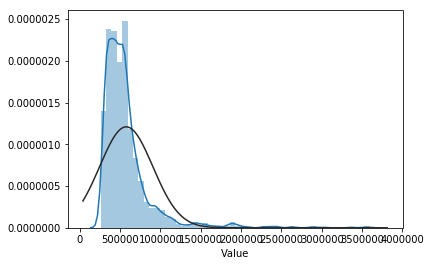

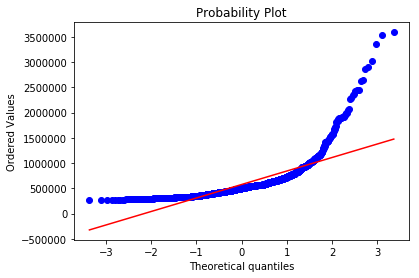

In [21]:
# histogram and normal probability plot
sns.distplot(grouped_df['Value'],fit=norm)
fig=plt.figure()
res=stats.probplot(grouped_df['Value'],plot=plt)

From the above distribution plot, we could see the price value deviate from normal distribution with positive skewness and high peakedness. Let's find out more about it.

In [22]:

print("Skewness: %f" % grouped_df['Value'].skew())
print("Kurtosis: %f" % grouped_df['Value'].kurt())

Skewness: 3.790724
Kurtosis: 20.985509


The skewness and kurtosis seems to be quite high. There are quite a few outliers above the 3000000 price point, let's see what we could do about it.

In [23]:
grouped_df.sort_values(by='Value',ascending=False).head()

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code
803,51.50,-0.15,0.300512,20916.108607,3.229508,3.592899e+06,E05000649
802,51.50,-0.16,0.324634,19207.815287,3.514331,3.530269e+06,E05009389
801,51.50,-0.17,0.478341,22730.391053,2.445887,3.368490e+06,E05009389
861,51.51,-0.15,0.326796,17618.875611,2.090496,3.027784e+06,E05000641
862,51.51,-0.14,0.289710,13002.229489,2.453270,2.912742e+06,E05000649


In [24]:
#Dropping the four outliers
filtered_df=grouped_df.drop(grouped_df[grouped_df['Value']>3000000].index)
#Checking if the outliers are dropped correctly
filtered_df.sort_values(by='Value',ascending=False).head()

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code
862,51.51,-0.14,0.289710,13002.229489,2.453270,2.912742e+06,E05000649
930,51.52,-0.15,0.397691,19451.257855,1.874317,2.861943e+06,E05000641
800,51.50,-0.18,0.446319,22561.076389,2.885417,2.653591e+06,E05009401
799,51.50,-0.19,0.293217,21941.395221,2.983456,2.618896e+06,E05009390
860,51.51,-0.16,0.236474,16917.021053,2.121053,2.454139e+06,E05000632


C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


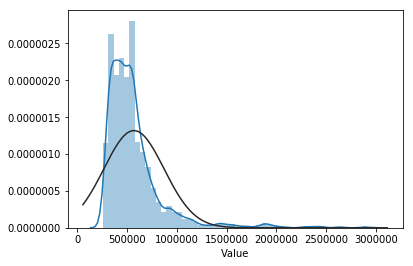

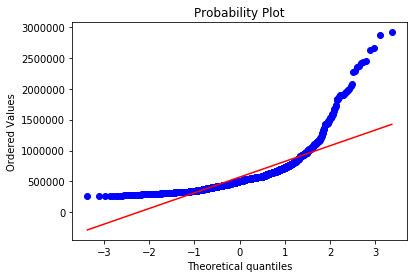

In [25]:
#plotting the distribution again

sns.distplot(filtered_df['Value'],fit=norm)
fig=plt.figure()
res=stats.probplot(filtered_df['Value'],plot=plt)

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


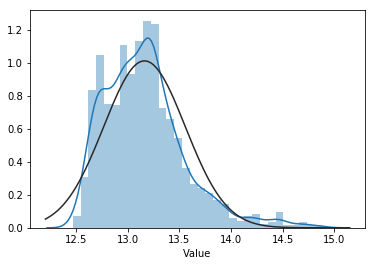

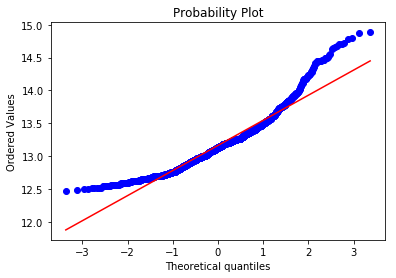

In [26]:
#Before removing any more outliers,let's check the logtransfomred plot
transformed_price=np.log(filtered_df['Value'])
sns.distplot(transformed_price,fit=norm)
fig=plt.figure()
res=stats.probplot(transformed_price,plot=plt)

Despite the relatively poor fit at the outer range,the distribution now looks a lot similar to the normal probability plot compared to the initial plot. We shall leave it for now as we might loose some important information if we remove too many outer range values. 

We shall now move on to examine our candidate features.

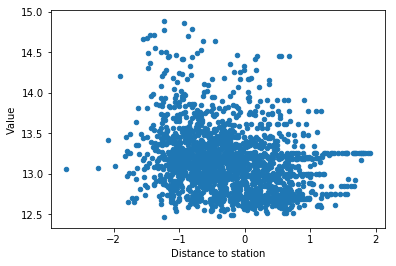

In [27]:
##Examining our first variable：Distance to Station
var='Distance to station'
data=pd.concat([transformed_price,np.log(filtered_df[var])],axis=1)
data.plot.scatter(x=var,y='Value')

Seems like our first candidate variable is not associated with the housing price, we shall exclude it from our model.

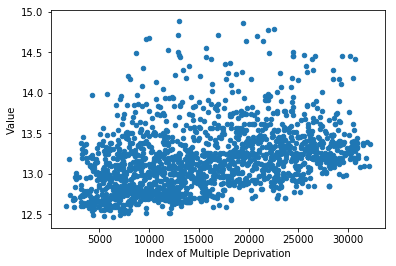

In [28]:
##Examining the second variable：Index of Multiple Deprivation
var='Index of Multiple Deprivation'
data=pd.concat([transformed_price,filtered_df[var]],axis=1)
data.plot.scatter(x=var,y='Value')

Interesting, the second feature variable does appear to be somewhat positively associated with the price value. However, the slope appears to be quite flat, it is possible that they are only weakly associated. Let's examine this variable in more details.

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


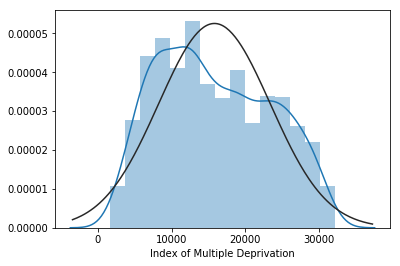

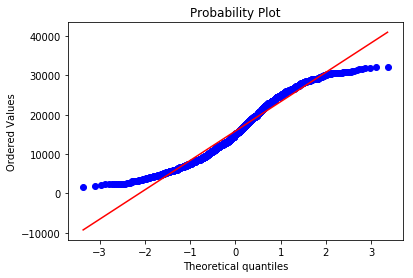

In [29]:
#Distribution Plot of the multiple index of deprivation
sns.distplot(filtered_df[var],fit=norm)
fig=plt.figure()
res=stats.probplot(filtered_df[var],plot=plt)

In [30]:

print("Skewness: %f" % filtered_df['Index of Multiple Deprivation'].skew())
print("Kurtosis: %f" % filtered_df['Index of Multiple Deprivation'].kurt())

Skewness: 0.227680
Kurtosis: -1.041539


From the distribution plot, we could see both tails (low end:below 5000; high end: above 30000) of the distribution have contributed to the poor fit. 

In [31]:
#We can see that most of the values at the higher end are indeed around 30000. 
#For the higher end, we shall set the outliers threshold at 30000.
filtered_df[var].sort_values(ascending=False).head(20)

1611    32217.000000
1342    32122.750000
72      31862.000000
1200    31793.137652
1343    31621.657895
223     31508.750000
1490    31464.732394
53      31201.615385
183     31016.984615
1199    30947.616667
1552    30928.521739
224     30918.530303
325     30879.741379
232     30873.123711
1423    30867.921053
50      30803.000000
1357    30725.145833
1274    30724.974359
49      30680.307692
1551    30672.041667
Name: Index of Multiple Deprivation, dtype: float64

In [32]:
#dropping the upper outliers
filtered_df=filtered_df.drop(filtered_df[filtered_df['Index of Multiple Deprivation']>30000].index)

From here we could see there are quite a few under 3000 values and it ranges from 1724.3.
To avoid missing important information, 
we will adopt a more conservative threshold (under 3000) for lower outliers .

In [33]:
filtered_df[var].sort_values(ascending=True).head()

1258    1629.000000
363     1921.270270
1523    2049.384615
1586    2341.278481
1691    2438.500000
Name: Index of Multiple Deprivation, dtype: float64

In [34]:
#dropping the lower outliers
filtered_df=filtered_df.drop(filtered_df[filtered_df['Index of Multiple Deprivation']<3000].index)

Skewness: 0.215889
Kurtosis: -1.089910


C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


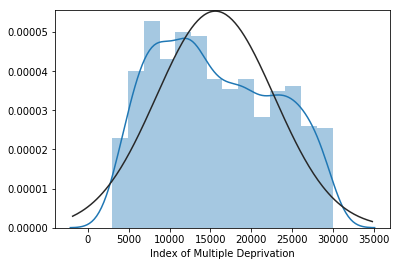

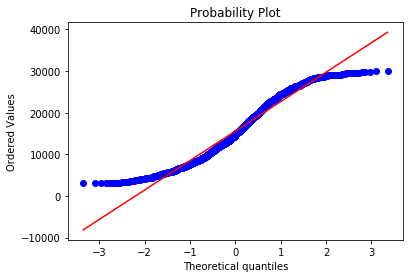

In [35]:
#Now let's have a look at the distribution again

sns.distplot(filtered_df['Index of Multiple Deprivation'], fit=norm)
fig=plt.figure()
stats.probplot(filtered_df['Index of Multiple Deprivation'], plot=plt)


print("Skewness: %f" % filtered_df['Index of Multiple Deprivation'].skew())
print("Kurtosis: %f" % filtered_df['Index of Multiple Deprivation'].kurt())

Although removing outliers did slightly reduce the skewness, the fit is still relatively poor at the end. However, before removing any more data, we shall examine the distribution again with log-transformed data.

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: -0.675117
Kurtosis: -0.262856


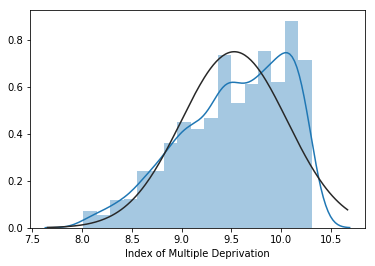

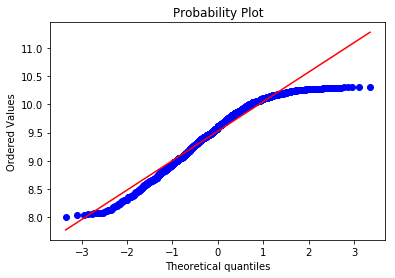

In [36]:
log_index=np.log(filtered_df['Index of Multiple Deprivation'])
sns.distplot(log_index, fit=norm)
fig=plt.figure()
stats.probplot(log_index, plot=plt)


print("Skewness: %f" % np.log(log_index).skew())
print("Kurtosis: %f" % np.log(log_index).kurt())

It does fit the normal distribution better now but the upper range is a bit off. We shall not remove any outliers for now.
Let's examine its association with price value again.

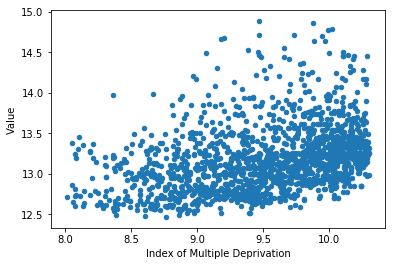

In [37]:
data=pd.concat([np.log(filtered_df['Index of Multiple Deprivation']), np.log(filtered_df['Value'])],axis=1)
data.plot.scatter(x='Index of Multiple Deprivation',y='Value')

In [38]:
from scipy.stats import linregress
linregress(log_index, np.log(filtered_df['Value']))

LinregressResult(slope=0.26339920621949625, intercept=10.65088513291543, rvalue=0.35541104373011984, pvalue=5.451140092383792e-53, stderr=0.01661157045286623)

From the results above, we could see the deprivation index is indeed significantly and positively correlated with the price value. Therefore, we will keep it as our feature variable.

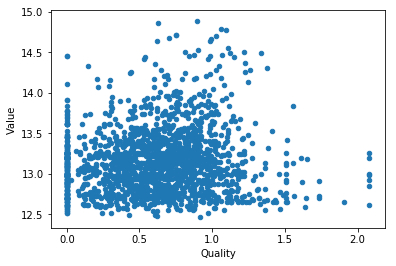

In [39]:
#Now move on the third candidate variable:Quality rating
var='Quality'
data=pd.concat([transformed_price,np.log(filtered_df[var])],axis=1)
data.plot.scatter(x=var,y='Value')

As shown above, the quality rating failed to provide any meaningful information about the price value, therefore, it will not be included in the modelling stage. Taken together, among the three candiate variables, only the depreivation index is retained as the feature variable. We shall now move on to source venue data using Foursquare API.

In [40]:
def getNearbyVenues(area_code,price,deprivation_index,latitude,longitude,radius=500):
    
    venues_list=[]
    for area_code,price,index,lat, lng in zip(area_code,price,deprivation_index,latitude,longitude):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        for i in range(3):
            response = requests.get(url).json()['response']
            
            if response.get('groups'):
                results = response['groups'][0]['items']
                break
                
            print('repeating')
            
        if not response.get('groups'):
            continue
                
        venues_list.append([(
            area_code,
            price,
            index,
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [ 
                  'Code',
                  'Price',
                  'Deprivation_index',
                  'District Latitude', 
                  'District Longitude',
                  'Venue',
                  'Venue ID', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [41]:


    
CLIENT_ID='JRMAOQ23QH2AR2G01QNCFARI5IKTISMVT2PHM3D0DXKGHF5N'
CLIENT_SECRET='M1P2CGJKPR0J1N1GMUV0P5CH1BGLFD3SHIPP4YTOFQ4NTATE'
VERSION = '20190128'
LIMIT=100

    

In [42]:
London_venues=getNearbyVenues(area_code=filtered_df['Code'],
                              price=np.log(filtered_df['Value']),
                              deprivation_index=np.log(filtered_df['Index of Multiple Deprivation']),
                              latitude=filtered_df['Latitude'],
                              longitude=filtered_df['Longitude'])



repeating


In [43]:
London_venues.head()

,Code,Price,Deprivation_index,District Latitude,District Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,E05000117,13.263071,9.889642,51.29,0.06,Shampan At The Spinning Wheel,4edb85d6e300851bfad7955e,51.292974,0.056939,Indian Restaurant
1,E05000117,13.263071,9.889642,51.29,0.06,Westerham Heights,59b435445a2c9107744a89d2,51.289698,0.057968,Scenic Lookout
2,E05000117,13.263071,9.889642,51.29,0.06,Biggin Hill Saddlery & Gun Room,5308c801498ebfb5ae1d784d,51.288883,0.058852,Gun Shop
3,E05000117,13.263071,9.889642,51.29,0.06,The Old Farmhouse,4e5d56d0d164ced553f6f6f6,51.293183,0.056939,Bed & Breakfast
4,E05000107,12.844880,10.053200,51.30,0.02,Pinky & Perky Manor,5843fe72d0bb3e5513d37dd9,51.303328,0.018773,Pizza Place


In [44]:
#Checking all the unique venue categories
London_venues['Venue Category'].unique()

array(['Indian Restaurant', 'Scenic Lookout', 'Gun Shop',
       'Bed & Breakfast', 'Pizza Place', 'Stables', 'Restaurant',
       'Train Station', 'Supermarket', 'Pool', 'Grocery Store',
       'Pharmacy', 'Café', 'Coffee Shop', 'Golf Course', 'Platform',
       'English Restaurant', 'Print Shop', 'Construction & Landscaping',
       'Motorcycle Shop', 'Airport Terminal', 'Pub', 'Music Venue',
       'Campground', 'Forest', 'Athletics & Sports', 'Auto Garage',
       'Clothing Store', 'Transportation Service', 'Gym / Fitness Center',
       'Home Service', 'Bar', 'Rock Club', 'Farm', 'IT Services',
       'Massage Studio', 'Airport', 'Airport Service', 'History Museum',
       'Lake', 'Garden Center', 'Convenience Store', 'Playground',
       'Asian Restaurant', 'Park', 'Tea Room', 'Sports Club',
       'Automotive Shop', 'Business Service', 'Arts & Crafts Store',
       'Bookstore', 'Theme Park Ride / Attraction', 'Aquarium',
       'Theme Park', 'Hotel', 'Theater', 'Zoo Exhibit',
  

In [45]:
len(London_venues['Venue Category'].unique()),London_venues.shape

(466, (18886, 10))

There seem to be quite a lot of venue categories, it is likely that not all of them are relevant in predicting housing price categories. Due to the large number of candidate features and its relatively large data size, we will use Random Forest, instead of Decision Tree to perform feature selection and calssification. 

In [46]:
#onehot_encoding: converting categorical variables into dummy variables
ld_onehot=pd.get_dummies(London_venues[['Venue Category']],prefix="",prefix_sep="")


In [47]:
ld_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#Inserting back the relevant columns
ld_onehot.insert(loc=0, column='Deprivation_index',value=London_venues['Deprivation_index'])
ld_onehot.insert(loc=0,column='Venue Latitude',value=London_venues['Venue Latitude'])
ld_onehot.insert(loc=0,column='Venue Longitude',value=London_venues['Venue Longitude'])
ld_onehot.insert(loc=0,column='Price',value=London_venues['Price'])

In [49]:
#creating a new price category feature by converting the price value into categorical variable by qualtiles
PriceCategory=pd.qcut(London_venues['Price'],3,labels=['low','medium','high'])
ld_onehot.insert(loc=0,column='PriceCategory',value=PriceCategory)

In [50]:
ld_onehot.head()

,PriceCategory,Price,Venue Longitude,Venue Latitude,Deprivation_index,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,medium,13.263071,0.056939,51.292974,9.889642,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,medium,13.263071,0.057968,51.289698,9.889642,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,medium,13.263071,0.058852,51.288883,9.889642,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,medium,13.263071,0.056939,51.293183,9.889642,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,low,12.844880,0.018773,51.303328,10.053200,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
ld_onehot.shape

(18886, 471)

In [52]:
x_1=ld_onehot.iloc[:,2:]
y_1=ld_onehot['PriceCategory']

## Modelling Stage: 
1. Apply the RandomForestClassifier to the whole dataset
2. Record the accuracy score
3. Select the important features
4. Apply the RandomForestClassifier again using the important features
5. Compare the accuracy score to the first model.
6. Apply the K-NearestNeighbours and Support Vector Machines with the selected features.
7. Record the accuracy of each model.
8. Select the model with the best accuracy score.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [54]:
#Performing 20/80 train_test split
x_train_1,x_test_1,y_train_1,y_test_1=train_test_split(x_1,y_1,test_size=0.2,random_state=4)

# Applying RandomForest to the whole dataset
rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(x_train_1,y_train_1)
#Accuracy of the first RandomForest Model
rf.score(x_test_1,y_test_1)

0.9526204340921123

In [55]:
#Generate a dataframe with the feature importance value array
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train_1.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [56]:
feature_importances.sort_values('importance',ascending=True).head()

,importance
Tanning Salon,0.0
Watch Shop,0.0
Japanese Curry Restaurant,0.0
Mobility Store,0.0
Knitting Store,0.0


As we can see, there are quite a few features with zero importance values. We shall remove those first.

In [57]:
#Removing features with zero importance value
important_feature=feature_importances[feature_importances['importance']!=0].reset_index()
feature_list=list(important_feature['index'])

#Modifying training and testing dataset accordingly.
x_train_imp=x_train_1[feature_list]
x_test_imp=x_test_1[feature_list]

In [58]:
#Applying the RandomForest again with reduced feature set
rf.fit(x_train_imp,y_train_1)
rf.score(x_test_imp,y_test_1)

0.9526204340921123

In [59]:
len(feature_list)

444

Dropping features with zero importance only improved our model performance by a slight margin. This is within our expectations as we still have a large number of feature variables left, which might contains variables that provide little meaningful information for price categoriy prediction, thereby introducing noise to the model. We shall now examine the impact of further feature reduction on model performance.

In [ ]:
#Setting the feature selection threshold : importance_rank >= 0.0015
impt_fea_2=list(feature_importances[feature_importances['importance']>=0.001].reset_index()['index'])
len(impt_fea_2)
x_impt_train_2=x_train_1[impt_fea_2]
x_impt_test_2=x_test_1[impt_fea_2]

In [61]:
rf.fit(x_impt_train_2,y_train_1)
rf.score(x_impt_test_2,y_test_1)

0.9788247750132345

By further reducing the number of feature variables, we have significantly improved our model accuracy. Now we will apply KNN and SVM to the selected feature sets.

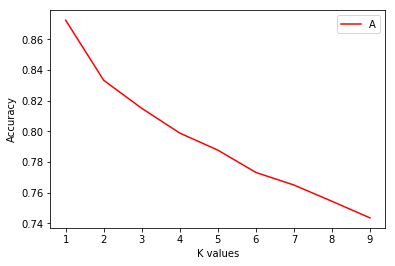

The best accuracy was obtained when K= 1 with Jaccard score= 0.8724192694547379


In [62]:
#Applying KNN algorithm
Ks=10
mean_acc=np.zeros(9)
std_acc=np.zeros(9)
for n in range (1,Ks):
    neigh=KNeighborsClassifier(n_neighbors=n).fit(x_impt_train_2,y_train_1)
    yhat=neigh.predict(x_impt_test_2)
    mean_acc[n-1]=metrics.accuracy_score(y_test_1,yhat)

plt.plot(range(1,Ks), mean_acc, 'r')
plt.legend('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('K values')
plt.show()

print( "The best accuracy was obtained when K=",  mean_acc.argmax()+1, "with Jaccard score=",mean_acc.max())

In [63]:
def SVM(x_train,y_train,x_test,y_test,KERNEL):
    svm_all=svm.SVC(kernel=KERNEL)
    svm_all.fit(x_train,y_train)
    yhat_svm_all=svm_all.predict(x_test)
    print(metrics.accuracy_score(y_test,yhat))
    svm_all_matrix=confusion_matrix(y_test,yhat_svm_all,labels=['high','medium','low'])
    np.set_printoptions()
    print(classification_report(y_test,yhat_svm_all))

In [ ]:
#Applying SVM algorithm
SVM(x_train=x_impt_train_2,y_train=y_train_1,x_test=x_impt_test_2,y_test=y_test_1,KERNEL='poly')

Compared to KNN and SVMs, RandomForestClassifier yielded the highest accuracy score(97.91%). Therefore, it is chosen as the best classfication model. 


It is worth noticing, however, the relatively high accuracy score does not provide any direct evidence for the strong predictive power of nearby venue category data. This is because,as shown in the feature_importances dataframe, the feature with the highest contribution value is the index of multiple deprivation. More importantly, its associated contribution value exceeded the value of the second most important feature by quite a considerable margin. Therefore it is possible that, venue categories data played a relatively insignificant role in predicting housing price categories. There are several possible explanations for this result. 

Firstly, this could be attributed to the lack of relationship between housing price categories and its nearby venue categories. Secondly, since the price value did not perfectly fit the normal distribution, it is possible that converting price values into cateogircal variables by quartiles might have resulted in a loss of information. Thus, the resulting classification model might not be a perfect reflection of the actual relationship between housing price and its nearby venue categories. Thirdly, the nearby venue data is limited to its functional categories, which provide little information about its associated expenditure level, which could potentially be a better predictor of housing price categories. This information could be sourced using the 'get venue details' query, however, due to the relatively large data size,
the number of API calls will exceed the quota of the current starndard Foursquare developer account. Therefore, future research with the additional focus on household expenditure level is suggested. Finally, only training and validation sets were used to evaluate prediction accuracy. If more time is allowed, a testing set will also be included to further examine the model generalisability, since it is possible the model will loose around 5% accuracy when applied to unseen data.

In [ ]:
feature_importances.sort_values('importance',ascending=False).head()

## References
Basu, S., & Thibodeau, T. G. (1998). Analysis of spatial autocorrelation in house prices. The Journal of Real Estate Finance and Economics, 17(1), 61-85.

Islam, K. S., & Asami, Y. (2009, July). Housing market segmentation: a review. In Review of Urban & Regional Development Studies: Journal of the Applied Regional Science Conference (Vol. 21, No. 2‐3, pp. 93-109). Melbourne, Australia: Blackwell Publishing Asia.

Margulis, H. L. (1998). Predicting the growth and filtering of at-risk housing: Structure ageing, poverty and redlining. Urban Studies, 35(8), 1231-1259.

